<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 3: Practical - Neural Network <br>
<font color=696880 size=4>
    Alireza Belal
    
    
____


# Setup

# 0. Preparation

In this part, you will use a dataset related to COVID-19. Load your dataset using pandas.

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
covid_data = pd.read_csv('Covid Dataset.csv')
categorical_feature_mask = covid_data.dtypes == object
cateforical_cols = covid_data.columns[categorical_feature_mask].tolist()
le = LabelEncoder()
covid_data[cateforical_cols] = covid_data[cateforical_cols].apply(lambda col: le.fit_transform(col))
covid_data = covid_data.astype(float)

# Extract X and Y from the dataset
X_total = covid_data.iloc[:, 0:20].values
y_total = covid_data.iloc[:,20].values


#SPLIT THE DATA INTO TRAIN AND TEST DATA 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_total, y_total, test_size = 0.3, random_state = 0)

In [2]:
covid_data.head()

,Breathing Problem,Fever,Dry Cough,Sore throat,Running Nose,Asthma,Chronic Lung Disease,Headache,Heart Disease,Diabetes,...,Fatigue,Gastrointestinal,Abroad travel,Contact with COVID Patient,Attended Large Gathering,Visited Public Exposed Places,Family working in Public Exposed Places,Wearing Masks,Sanitization from Market,COVID-19
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0


---------------

# 1. DNN as nonlinear dimensionality reduction method (50 Points)

Autoencoder is an unsupervised artificial neural network that compresses the data to lower dimension and then reconstructs the input back. Autoencoder finds the representation of the data in a lower dimension by focusing more on the important features getting rid of noise and redundancy. It's based on Encoder-Decoder architecture, where encoder encodes the high-dimensional data to lower-dimension and decoder takes the lower-dimensional data and tries to reconstruct the original high-dimensional data.

![picture](https://drive.google.com/uc?id=1RTZwx4xL6zFV_nUENBgWlFKLKldPoyI-)

In the above Diagram, X is the input data, z is the lower-dimension representation of input X and X’ is the reconstructed input data. The mapping of higher to lower dimensions can be linear or non-linear depending on the choice of the activation function.

In this part you're gonna implement an autoencoder using Keras framework as dimensionally reduction module as explained [here](https://blog.keras.io/building-autoencoders-in-keras.html).
(It would be ok to use PyTorch as well.)
Reduce the dimension of the data to 2 dimensions and visualize the low-dimensional data.

In [4]:
# import necessary libraries

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.autograd import Variable 

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_test = torch.tensor(X_test)
Y_test = torch.tensor(y_test)

In [7]:
train_loader = DataLoader(list(zip(X_train, y_train)), batch_size=30, shuffle=True)

test_loader = DataLoader(list(zip(X_test, y_test)), batch_size=30, shuffle=False)


In [40]:
# define layers (25 Points)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # encoder
        self.lin1 = nn.Linear(20, 10)
        self.relu1 = nn.ReLU()
        self.batch1 = nn.BatchNorm1d(10)
        self.lin2 = nn.Linear(10, 5)
        self.relu2 = nn.ReLU()
        self.lin3 = nn.Linear(5, 2)
        
        #decoder
        self.lin4 = nn.Linear(2, 5)
        self.relu3 = nn.ReLU()
        self.batch2 = nn.BatchNorm1d(5)
        self.lin5 = nn.Linear(5, 10)
        self.relu4 = nn.ReLU()
        self.lin6 = nn.Linear(10, 20)
        
    def encode(self, x):
        x = self.batch1(self.relu1(self.lin1(x)))
        x = self.relu2(self.lin2(x))
        x = self.lin3(x)
        
        return x
    
    
    def decode(self, x):
        x = self.batch2(self.relu3(self.lin4(x)))
        x = self.relu4(self.lin5(x))
        x = self.lin6(x)
        
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        
        return x
    

In [41]:
# train the model and reduce the dimension of the data (15 Points)

model = Autoencoder().to(device)
criterion = nn.MSELoss() # Write your code here
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01) # Write your code here

total_step = len(train_loader)
num_epochs = 100

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    total = 0
    total_loss = 0
    
    model.train()
    with tqdm(enumerate(train_loader), total=total_step) as pbar:
        for i, (X, y) in pbar:  
            X, y = X.to(device), y.to(device)
            
            inputs = Variable(X)
            targets = Variable(X)
            
            optimizer.zero_grad()
            output = model(inputs.float())
            loss = criterion(output, targets.float())
            
            
            total_loss += loss.item()
            total += y.size(0)

            loss.backward()
            optimizer.step()
         
        tloss = total_loss/total_step
        
    train_losses.append(tloss)
    print('train epooch {}: loss={}'.format(epoch, tloss))
    
    
    total = 0
    total_loss = 0
    
    model.eval()
    with torch.no_grad(), tqdm(enumerate(test_loader), total = len(test_loader)) as pbar:
        for i, (X, y) in pbar:
            X, y = X.to(device), y.to(device)
            
            inputs = Variable(X)
            targets = Variable(X)
            
            output = model(inputs.float())
            loss = criterion(output, targets.float())
            
            
            total_loss += loss.item()
            total += y.size(0)
            
    tloss = total_loss/len(test_loader)
        
    val_losses.append(tloss)
    print('validation epooch {}:loss={}'.format(epoch, tloss))

    

100%|████████████████████████████████████████| 127/127 [00:00<00:00, 825.67it/s]


train epooch 0: loss=0.20781302264356238


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5249.08it/s]


validation epooch 0:loss=0.1743619677695361


100%|████████████████████████████████████████| 127/127 [00:00<00:00, 980.76it/s]


train epooch 1: loss=0.17132772998077664


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5020.49it/s]


validation epooch 1:loss=0.16629755144769495


100%|████████████████████████████████████████| 127/127 [00:00<00:00, 998.34it/s]


train epooch 2: loss=0.16721937471018064


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5477.02it/s]


validation epooch 2:loss=0.1658575410192663


100%|████████████████████████████████████████| 127/127 [00:00<00:00, 994.03it/s]


train epooch 3: loss=0.164141430512188


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5501.71it/s]


validation epooch 3:loss=0.1602753452279351


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1004.26it/s]


train epooch 4: loss=0.1600679847903139


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5306.92it/s]


validation epooch 4:loss=0.1569272057576613


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1003.81it/s]


train epooch 5: loss=0.15810900633260022


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5619.79it/s]


validation epooch 5:loss=0.157198627428575


100%|████████████████████████████████████████| 127/127 [00:00<00:00, 840.94it/s]


train epooch 6: loss=0.15738450072881743


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5560.06it/s]


validation epooch 6:loss=0.15491403341293336


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1008.75it/s]


train epooch 7: loss=0.1566397977156902


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5702.59it/s]


validation epooch 7:loss=0.1530184805393219


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1002.30it/s]


train epooch 8: loss=0.15584096981315163


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5645.78it/s]


validation epooch 8:loss=0.15276986360549927


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1010.66it/s]


train epooch 9: loss=0.15596556264584457


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5661.44it/s]


validation epooch 9:loss=0.1602233046835119


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1012.34it/s]


train epooch 10: loss=0.15553656490299644


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5801.10it/s]


validation epooch 10:loss=0.15245469375090165


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1008.17it/s]


train epooch 11: loss=0.15458566478387578


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5748.34it/s]


validation epooch 11:loss=0.15222453014417128


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1005.83it/s]


train epooch 12: loss=0.1541279695165439


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5657.83it/s]


validation epooch 12:loss=0.15190170000899922


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1008.40it/s]


train epooch 13: loss=0.15447361438762486


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5700.61it/s]


validation epooch 13:loss=0.1532567641951821


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.59it/s]


train epooch 14: loss=0.1532021589635864


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5753.36it/s]


validation epooch 14:loss=0.1518808370286768


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.15it/s]


train epooch 15: loss=0.1535785446955463


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5833.82it/s]


validation epooch 15:loss=0.14981574578718707


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.84it/s]


train epooch 16: loss=0.15226763639393753


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5735.76it/s]


validation epooch 16:loss=0.15005697147412733


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.66it/s]


train epooch 17: loss=0.15204914078468412


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5818.81it/s]


validation epooch 17:loss=0.14972225806929848


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1027.59it/s]


train epooch 18: loss=0.15211092839090842


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5797.90it/s]


validation epooch 18:loss=0.1492066350850192


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.42it/s]


train epooch 19: loss=0.15148732048554683


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5817.64it/s]


validation epooch 19:loss=0.1468256493861025


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.59it/s]


train epooch 20: loss=0.15053629323722809


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5823.36it/s]


validation epooch 20:loss=0.14906855604865335


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1015.80it/s]


train epooch 21: loss=0.15139083411749893


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5773.09it/s]


validation epooch 21:loss=0.1465691170909188


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1016.48it/s]


train epooch 22: loss=0.15064107339213215


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5789.60it/s]


validation epooch 22:loss=0.14798042503270237


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1016.58it/s]


train epooch 23: loss=0.15051368747170515


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5743.05it/s]


validation epooch 23:loss=0.14690466902472757


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.53it/s]


train epooch 24: loss=0.15199248832980478


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5773.66it/s]


validation epooch 24:loss=0.14681040996854955


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1013.50it/s]


train epooch 25: loss=0.15204009167322025


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5721.96it/s]


validation epooch 25:loss=0.1474976206367666


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1006.41it/s]


train epooch 26: loss=0.15002192005397766


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5788.30it/s]


validation epooch 26:loss=0.14643030925230546


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.63it/s]


train epooch 27: loss=0.15020519759007325


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5723.81it/s]


validation epooch 27:loss=0.14601986462419683


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.60it/s]


train epooch 28: loss=0.1504918449506985


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5777.28it/s]


validation epooch 28:loss=0.14704775756055657


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.46it/s]


train epooch 29: loss=0.14941264008443186


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5783.51it/s]


validation epooch 29:loss=0.1457658820531585


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.28it/s]


train epooch 30: loss=0.1503564815117618


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5791.35it/s]


validation epooch 30:loss=0.14696999869563362


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.03it/s]


train epooch 31: loss=0.14988135024318544


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5814.56it/s]


validation epooch 31:loss=0.1438479721546173


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.95it/s]


train epooch 32: loss=0.14899018242603213


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5829.99it/s]


validation epooch 32:loss=0.14375893609090284


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1017.96it/s]


train epooch 33: loss=0.1489499748691799


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5844.16it/s]


validation epooch 33:loss=0.14434648725119503


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.69it/s]


train epooch 34: loss=0.14816122120759617


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5813.97it/s]


validation epooch 34:loss=0.14478776034983723


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.80it/s]


train epooch 35: loss=0.14922292512936855


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5834.41it/s]


validation epooch 35:loss=0.14413012848658996


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.84it/s]


train epooch 36: loss=0.14884063648426626


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5788.30it/s]


validation epooch 36:loss=0.14392175769264048


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.29it/s]


train epooch 37: loss=0.14850919300646293


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5708.94it/s]


validation epooch 37:loss=0.1441770461472598


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.55it/s]


train epooch 38: loss=0.14937458967599343


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5790.04it/s]


validation epooch 38:loss=0.14481696459380064


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.18it/s]


train epooch 39: loss=0.14704908172445974


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5762.27it/s]


validation epooch 39:loss=0.14420644681562078


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.34it/s]


train epooch 40: loss=0.14817051272692644


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5779.74it/s]


validation epooch 40:loss=0.14405803978443146


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.27it/s]


train epooch 41: loss=0.1480528303957361


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5767.60it/s]


validation epooch 41:loss=0.14333575313741512


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.36it/s]


train epooch 42: loss=0.1489965807734512


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5806.65it/s]


validation epooch 42:loss=0.14342739135026933


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.53it/s]


train epooch 43: loss=0.14861092434858714


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5733.91it/s]


validation epooch 43:loss=0.14408046982505104


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1016.13it/s]


train epooch 44: loss=0.14776942444833244


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5828.66it/s]


validation epooch 44:loss=0.14352003986185247


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.03it/s]


train epooch 45: loss=0.14855985683719003


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5810.16it/s]


validation epooch 45:loss=0.1453736195510084


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.11it/s]


train epooch 46: loss=0.1476753369325728


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5777.42it/s]


validation epooch 46:loss=0.14403384774923325


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.27it/s]


train epooch 47: loss=0.14791025514677753


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5806.07it/s]


validation epooch 47:loss=0.1446673624894836


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.25it/s]


train epooch 48: loss=0.14717775501134828


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5794.98it/s]


validation epooch 48:loss=0.14430204358967869


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.72it/s]


train epooch 49: loss=0.14718437799083905


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5781.04it/s]


validation epooch 49:loss=0.14405877183784138


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1026.30it/s]


train epooch 50: loss=0.1473053026152408


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5796.88it/s]


validation epooch 50:loss=0.1436207960952412


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.46it/s]


train epooch 51: loss=0.14824716570809132


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5779.16it/s]


validation epooch 51:loss=0.14442672417922453


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.82it/s]


train epooch 52: loss=0.1473869822156711


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5878.12it/s]


validation epooch 52:loss=0.14309336759827354


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.38it/s]


train epooch 53: loss=0.14767185745276803


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5768.90it/s]


validation epooch 53:loss=0.14224676083434712


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.81it/s]


train epooch 54: loss=0.1478242411270855


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5787.13it/s]


validation epooch 54:loss=0.1414113456552679


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1027.28it/s]


train epooch 55: loss=0.14852502836486486


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5733.91it/s]


validation epooch 55:loss=0.14155727516521108


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.01it/s]


train epooch 56: loss=0.14694052999179194


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5794.40it/s]


validation epooch 56:loss=0.14371594447981229


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.32it/s]


train epooch 57: loss=0.14629231141073498


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5777.42it/s]


validation epooch 57:loss=0.14228615869175304


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.82it/s]


train epooch 58: loss=0.14685116966409006


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5753.07it/s]


validation epooch 58:loss=0.14209197935732928


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1026.95it/s]


train epooch 59: loss=0.14705540245677542


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5735.19it/s]


validation epooch 59:loss=0.14170601002194666


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.77it/s]


train epooch 60: loss=0.147255704569535


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5760.97it/s]


validation epooch 60:loss=0.1424302649768916


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.59it/s]


train epooch 61: loss=0.14684628513384992


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5743.05it/s]


validation epooch 61:loss=0.142185600372878


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1028.72it/s]


train epooch 62: loss=0.14724594806357633


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5844.91it/s]


validation epooch 62:loss=0.14316790103912352


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.73it/s]


train epooch 63: loss=0.14707725125504292


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5770.77it/s]


validation epooch 63:loss=0.14071418290788476


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.79it/s]


train epooch 64: loss=0.14624181700738395


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5846.09it/s]


validation epooch 64:loss=0.14185220843011684


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1017.70it/s]


train epooch 65: loss=0.1468615247978


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5818.37it/s]


validation epooch 65:loss=0.14214042912830005


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.00it/s]


train epooch 66: loss=0.1476096016332859


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5730.92it/s]


validation epooch 66:loss=0.14151075170798735


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.64it/s]


train epooch 67: loss=0.1474288511933304


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5825.13it/s]


validation epooch 67:loss=0.14467521675608375


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.98it/s]


train epooch 68: loss=0.14658747331833277


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5864.07it/s]


validation epooch 68:loss=0.142039285058325


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.88it/s]


train epooch 69: loss=0.14639591220326312


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5754.94it/s]


validation epooch 69:loss=0.1428908255967227


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.54it/s]


train epooch 70: loss=0.14701572617911918


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5728.07it/s]


validation epooch 70:loss=0.14153735136443918


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.28it/s]


train epooch 71: loss=0.14624437020988915


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5826.16it/s]


validation epooch 71:loss=0.1411566127430309


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.17it/s]


train epooch 72: loss=0.1462198688289312


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5831.17it/s]


validation epooch 72:loss=0.14204172126271508


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1023.00it/s]


train epooch 73: loss=0.14647856061383496


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5793.67it/s]


validation epooch 73:loss=0.14230832010507583


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.36it/s]


train epooch 74: loss=0.14712858188340044


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5759.11it/s]


validation epooch 74:loss=0.14160709909417413


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.29it/s]


train epooch 75: loss=0.14721733143949134


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5784.67it/s]


validation epooch 75:loss=0.14136857417496768


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.34it/s]


train epooch 76: loss=0.14629638065972667


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5777.86it/s]


validation epooch 76:loss=0.14328817454251377


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.41it/s]


train epooch 77: loss=0.14693422850192062


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5753.79it/s]


validation epooch 77:loss=0.14271888909014788


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.79it/s]


train epooch 78: loss=0.14670310251590774


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5811.48it/s]


validation epooch 78:loss=0.1425881946628744


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1016.29it/s]


train epooch 79: loss=0.1470659274285234


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5758.10it/s]


validation epooch 79:loss=0.14009835543957624


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.92it/s]


train epooch 80: loss=0.14703890575668005


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5721.40it/s]


validation epooch 80:loss=0.14002910337664864


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.12it/s]


train epooch 81: loss=0.1453915982265172


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5771.35it/s]


validation epooch 81:loss=0.1417200501669537


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.84it/s]


train epooch 82: loss=0.14619025365104826


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5776.12it/s]


validation epooch 82:loss=0.1412962489507415


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.93it/s]


train epooch 83: loss=0.14597264295957219


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5777.86it/s]


validation epooch 83:loss=0.14159801466898483


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.09it/s]


train epooch 84: loss=0.1485975768387787


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5848.02it/s]


validation epooch 84:loss=0.1428734288974242


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1028.03it/s]


train epooch 85: loss=0.14638365928347655


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5819.40it/s]


validation epooch 85:loss=0.14223346669565548


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1019.30it/s]


train epooch 86: loss=0.1458033142596718


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5842.39it/s]


validation epooch 86:loss=0.1409015579657121


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1026.56it/s]


train epooch 87: loss=0.14713279715203864


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5839.87it/s]


validation epooch 87:loss=0.14190552884882146


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1027.78it/s]


train epooch 88: loss=0.14728645434764426


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5825.57it/s]


validation epooch 88:loss=0.1416614970022982


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.83it/s]


train epooch 89: loss=0.1480125951485371


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5859.16it/s]


validation epooch 89:loss=0.1415529335086996


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.46it/s]


train epooch 90: loss=0.14640865392806962


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5795.57it/s]


validation epooch 90:loss=0.1406681935895573


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1018.94it/s]


train epooch 91: loss=0.14546187873196414


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5816.46it/s]


validation epooch 91:loss=0.1415580371564085


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1026.06it/s]


train epooch 92: loss=0.14672399277058173


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5862.43it/s]


validation epooch 92:loss=0.14133731668645685


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.45it/s]


train epooch 93: loss=0.1459841995140699


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5754.94it/s]


validation epooch 93:loss=0.140690832788294


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1021.88it/s]


train epooch 94: loss=0.1462227256865952


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5781.04it/s]


validation epooch 94:loss=0.14189470180056313


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1020.51it/s]


train epooch 95: loss=0.1473071627964185


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5771.35it/s]


validation epooch 95:loss=0.14197806892069903


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1025.86it/s]


train epooch 96: loss=0.14645069004513148


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5726.08it/s]


validation epooch 96:loss=0.14096693816510114


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.54it/s]


train epooch 97: loss=0.14618203349000825


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5759.68it/s]


validation epooch 97:loss=0.14183495125987314


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1024.15it/s]


train epooch 98: loss=0.14572196195679388


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5758.53it/s]


validation epooch 98:loss=0.1409931635314768


100%|███████████████████████████████████████| 127/127 [00:00<00:00, 1022.55it/s]


train epooch 99: loss=0.145893543606668


100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 5677.04it/s]

validation epooch 99:loss=0.14195313494313846


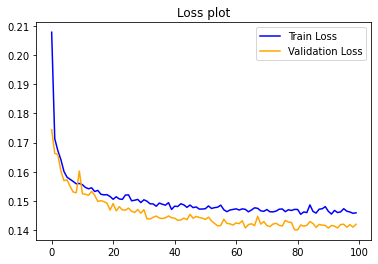

In [42]:
plt.plot(train_losses, color = 'blue', label = 'Train Loss')
plt.plot(val_losses, color = 'orange', label = 'Validation Loss')
plt.title('Loss plot')
plt.legend(loc ='upper right')

In [43]:
total = 0
total_loss = 0

results = []
model.eval()
with torch.no_grad(), tqdm(enumerate(test_loader), total = len(test_loader)) as pbar:
    for i, (X, y) in pbar:
        X, y = X.to(device), y.to(device)
            
        inputs = Variable(X)
        targets = Variable(X)
            
        output = model(inputs.float())
        res = model.encode(inputs.float())
        results.append(res)
        
        loss = criterion(output, targets.float())
            
            
        total_loss += loss.item()
        total += y.size(0)
            
tloss = total_loss/len(test_loader)
        
print('test :loss={}'.format(tloss))

100%|█████████████████████████████████████████| 55/55 [00:00<00:00, 1646.10it/s]

test :loss=0.14195313494313846


In [44]:
# appending the reduced data from training dataset
model.eval()
with torch.no_grad(), tqdm(enumerate(train_loader), total = len(train_loader)) as pbar:
    for i, (X, y) in pbar:
        X, y = X.to(device), y.to(device)
            
        inputs = Variable(X)
        targets = Variable(X)
            
        res = model.encode(inputs.float())
        results.append(res)

100%|███████████████████████████████████████| 127/127 [00:00<00:00, 3605.38it/s]


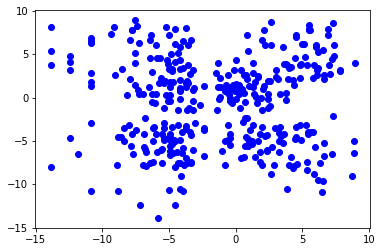

In [45]:
# Plot the encoded data (10 Points)

for x in results:
    plt.scatter(x[0], x[1], color = 'blue')